In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.optimizers import Adam
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
dataset = pd.read_csv('../data/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


In [4]:
print(data.columns)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
# specify the number of lag hours
n_hours = 24*7
K = 24

In [6]:
# Pre-processing
# Stage --> 8 stages
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96241, 768)


In [7]:
# stages_head = dataset[['HWS_S25A', 'HWS_S25B', 'HWS_S26']]
# print("stages_head.shape:", stages_head.shape)

# stages_head_supervised = series_to_supervised(stages_head, n_hours, K)
# print("stages_head_supervised.shape:", stages_head_supervised.shape)

#### Non-stage

In [8]:
# non_stages = data[['WS_S4', 'FLOW_S25A', 'GATE_S25A', 'FLOW_S25B', 'GATE_S25B', 'FLOW_S26', 'GATE_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
non_stages = data[['WS_S4', 'FLOW_S25A', 'FLOW_S25B', 'FLOW_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
print("non_stages.shape:", non_stages.shape)

non_stages_supervised = series_to_supervised(non_stages, n_hours-1, 1)
print("non_stages_supervised.shape:", non_stages_supervised.shape)

non_stages.shape: (96432, 7)
non_stages_supervised.shape: (96265, 1176)


In [9]:
non_stages_supervised_cut = non_stages_supervised.iloc[24:, :]
print("non_stages_supervised_cut.shape:", non_stages_supervised_cut.shape)

non_stages_supervised_cut.shape: (96241, 1176)


In [10]:
# non_stages_supervised_cut

### N_out, N_in, K

In [11]:
# specify the number of lag hours
# n_hours = 72, stages_head.shape[1] + 
n_features = stages.shape[1] + non_stages.shape[1]   # 1 rainfall + FGate_S25A + FGate_S25B + FGate_S26 + 8WS + PUMP_S26
# K = 12

In [12]:
n_features

11

### Concatenation

In [13]:
# stages_head_supervised.reset_index(drop=True, inplace=True)
non_stages_supervised_cut.reset_index(drop=True, inplace=True)
stages_supervised.reset_index(drop=True, inplace=True)

all_data = concat([
                   non_stages_supervised_cut.iloc[:, :],
#                    stages_head_supervised.iloc[:, :-3*K],
                   stages_supervised.iloc[:, :]],
                   axis=1)

In [14]:
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96241, 1944)


### Train & Test set

In [15]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 76992


### Normalization

In [16]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -stages.shape[1]*K:]
test_X, test_y = test[:, :n_obs], test[:, -stages.shape[1]*K:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (76992, 1848) (76992, 96) (19249, 1848) (19249, 96)


In [17]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (76992, 168, 11) (76992, 96) (19249, 168, 11) (19249, 96)


### Model
- filters=64, kernel_size=12, activation='relu', Dense(32), epoch=2000 --> 0.0010
- filters=64, kernel_size=3, activation='relu', Dense(32), epoch=3000 --> 0.0008

In [19]:
# define model
model_conv_mlp_60 = keras.Sequential()
model_conv_mlp_60.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model_conv_mlp_60.add(layers.MaxPooling1D(pool_size=2))
model_conv_mlp_60.add(layers.Flatten())
# model_conv_mlp_60.add(layers.Dense(32, activation='relu'))
model_conv_mlp_60.add(layers.Dense(train_y.shape[1]))
model_conv_mlp_60.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 166, 64)           2176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 83, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5312)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                510048    
Total params: 512,224
Trainable params: 512,224
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2000


2023-03-23 02:57:58.215243: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-23 02:57:58.454303: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-03-23 02:57:59.399097: E tensorflow/stream_executor/gpu/asm_compiler.cc:110] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 9.2.88).  Compilation of XLA kernels below will likely fail.

You do not need to update CUDA; cherry-picking the ptxas binary is sufficient.
2023-03-23 02:57:59.488549: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 65280, output: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.



Epoch 00001: val_mae improved from inf to 0.15281, saving model to saved_model/cnn_11.h5
151/151 - 4s - loss: 0.0573 - mae: 0.1877 - val_loss: 0.0361 - val_mae: 0.1528
Epoch 2/2000

Epoch 00002: val_mae improved from 0.15281 to 0.12440, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 0.0158 - mae: 0.1009 - val_loss: 0.0237 - val_mae: 0.1244
Epoch 3/2000

Epoch 00003: val_mae improved from 0.12440 to 0.10712, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 0.0112 - mae: 0.0841 - val_loss: 0.0179 - val_mae: 0.1071
Epoch 4/2000

Epoch 00004: val_mae improved from 0.10712 to 0.09382, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 0.0083 - mae: 0.0716 - val_loss: 0.0139 - val_mae: 0.0938
Epoch 5/2000

Epoch 00005: val_mae improved from 0.09382 to 0.08449, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 0.0065 - mae: 0.0627 - val_loss: 0.0114 - val_mae: 0.0845
Epoch 6/2000

Epoch 00006: val_mae improved from 0.08449 to 0.07842, saving model to sa

Epoch 45/2000

Epoch 00045: val_mae improved from 0.04563 to 0.04532, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 0.0016 - mae: 0.0302 - val_loss: 0.0034 - val_mae: 0.0453
Epoch 46/2000

Epoch 00046: val_mae improved from 0.04532 to 0.04502, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 0.0016 - mae: 0.0300 - val_loss: 0.0033 - val_mae: 0.0450
Epoch 47/2000

Epoch 00047: val_mae improved from 0.04502 to 0.04473, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 0.0016 - mae: 0.0297 - val_loss: 0.0033 - val_mae: 0.0447
Epoch 48/2000

Epoch 00048: val_mae improved from 0.04473 to 0.04445, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 0.0015 - mae: 0.0294 - val_loss: 0.0032 - val_mae: 0.0444
Epoch 49/2000

Epoch 00049: val_mae improved from 0.04445 to 0.04417, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 0.0015 - mae: 0.0292 - val_loss: 0.0032 - val_mae: 0.0442
Epoch 50/2000

Epoch 00050: val_mae improved from 0.04417 to 0.04

Epoch 89/2000

Epoch 00089: val_mae improved from 0.03695 to 0.03682, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 9.7142e-04 - mae: 0.0230 - val_loss: 0.0022 - val_mae: 0.0368
Epoch 90/2000

Epoch 00090: val_mae improved from 0.03682 to 0.03670, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 9.6337e-04 - mae: 0.0229 - val_loss: 0.0022 - val_mae: 0.0367
Epoch 91/2000

Epoch 00091: val_mae improved from 0.03670 to 0.03658, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 9.5546e-04 - mae: 0.0228 - val_loss: 0.0022 - val_mae: 0.0366
Epoch 92/2000

Epoch 00092: val_mae improved from 0.03658 to 0.03646, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 9.4771e-04 - mae: 0.0227 - val_loss: 0.0022 - val_mae: 0.0365
Epoch 93/2000

Epoch 00093: val_mae improved from 0.03646 to 0.03634, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 9.4010e-04 - mae: 0.0226 - val_loss: 0.0021 - val_mae: 0.0363
Epoch 94/2000

Epoch 00094: val_mae improved 

Epoch 132/2000

Epoch 00132: val_mae improved from 0.03281 to 0.03273, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 7.2349e-04 - mae: 0.0196 - val_loss: 0.0017 - val_mae: 0.0327
Epoch 133/2000

Epoch 00133: val_mae improved from 0.03273 to 0.03266, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 7.1944e-04 - mae: 0.0195 - val_loss: 0.0017 - val_mae: 0.0327
Epoch 134/2000

Epoch 00134: val_mae improved from 0.03266 to 0.03259, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 7.1545e-04 - mae: 0.0195 - val_loss: 0.0017 - val_mae: 0.0326
Epoch 135/2000

Epoch 00135: val_mae improved from 0.03259 to 0.03252, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 7.1150e-04 - mae: 0.0194 - val_loss: 0.0017 - val_mae: 0.0325
Epoch 136/2000

Epoch 00136: val_mae improved from 0.03252 to 0.03244, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 7.0761e-04 - mae: 0.0193 - val_loss: 0.0017 - val_mae: 0.0324
Epoch 137/2000

Epoch 00137: val_mae imp

Epoch 175/2000

Epoch 00175: val_mae improved from 0.03014 to 0.03009, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 5.8864e-04 - mae: 0.0175 - val_loss: 0.0015 - val_mae: 0.0301
Epoch 176/2000

Epoch 00176: val_mae improved from 0.03009 to 0.03003, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 5.8625e-04 - mae: 0.0174 - val_loss: 0.0015 - val_mae: 0.0300
Epoch 177/2000

Epoch 00177: val_mae improved from 0.03003 to 0.02998, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 5.8389e-04 - mae: 0.0174 - val_loss: 0.0015 - val_mae: 0.0300
Epoch 178/2000

Epoch 00178: val_mae improved from 0.02998 to 0.02993, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 5.8155e-04 - mae: 0.0174 - val_loss: 0.0014 - val_mae: 0.0299
Epoch 179/2000

Epoch 00179: val_mae improved from 0.02993 to 0.02988, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 5.7924e-04 - mae: 0.0173 - val_loss: 0.0014 - val_mae: 0.0299
Epoch 180/2000

Epoch 00180: val_mae imp

Epoch 218/2000

Epoch 00218: val_mae improved from 0.02822 to 0.02818, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 5.0514e-04 - mae: 0.0161 - val_loss: 0.0013 - val_mae: 0.0282
Epoch 219/2000

Epoch 00219: val_mae improved from 0.02818 to 0.02815, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 5.0357e-04 - mae: 0.0160 - val_loss: 0.0013 - val_mae: 0.0281
Epoch 220/2000

Epoch 00220: val_mae improved from 0.02815 to 0.02811, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 5.0201e-04 - mae: 0.0160 - val_loss: 0.0013 - val_mae: 0.0281
Epoch 221/2000

Epoch 00221: val_mae improved from 0.02811 to 0.02807, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 5.0047e-04 - mae: 0.0160 - val_loss: 0.0013 - val_mae: 0.0281
Epoch 222/2000

Epoch 00222: val_mae improved from 0.02807 to 0.02803, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 4.9895e-04 - mae: 0.0160 - val_loss: 0.0013 - val_mae: 0.0280
Epoch 223/2000

Epoch 00223: val_mae imp

Epoch 261/2000

Epoch 00261: val_mae improved from 0.02677 to 0.02674, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 4.4806e-04 - mae: 0.0150 - val_loss: 0.0012 - val_mae: 0.0267
Epoch 262/2000

Epoch 00262: val_mae improved from 0.02674 to 0.02671, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 4.4694e-04 - mae: 0.0150 - val_loss: 0.0012 - val_mae: 0.0267
Epoch 263/2000

Epoch 00263: val_mae improved from 0.02671 to 0.02669, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 4.4583e-04 - mae: 0.0150 - val_loss: 0.0011 - val_mae: 0.0267
Epoch 264/2000

Epoch 00264: val_mae improved from 0.02669 to 0.02666, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 4.4473e-04 - mae: 0.0150 - val_loss: 0.0011 - val_mae: 0.0267
Epoch 265/2000

Epoch 00265: val_mae improved from 0.02666 to 0.02663, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 4.4363e-04 - mae: 0.0149 - val_loss: 0.0011 - val_mae: 0.0266
Epoch 266/2000

Epoch 00266: val_mae imp

Epoch 304/2000

Epoch 00304: val_mae improved from 0.02565 to 0.02563, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 4.0598e-04 - mae: 0.0142 - val_loss: 0.0011 - val_mae: 0.0256
Epoch 305/2000

Epoch 00305: val_mae improved from 0.02563 to 0.02560, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 4.0513e-04 - mae: 0.0142 - val_loss: 0.0011 - val_mae: 0.0256
Epoch 306/2000

Epoch 00306: val_mae improved from 0.02560 to 0.02558, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 4.0428e-04 - mae: 0.0142 - val_loss: 0.0011 - val_mae: 0.0256
Epoch 307/2000

Epoch 00307: val_mae improved from 0.02558 to 0.02556, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 4.0343e-04 - mae: 0.0142 - val_loss: 0.0011 - val_mae: 0.0256
Epoch 308/2000

Epoch 00308: val_mae improved from 0.02556 to 0.02554, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 4.0260e-04 - mae: 0.0142 - val_loss: 0.0011 - val_mae: 0.0255
Epoch 309/2000

Epoch 00309: val_mae imp

Epoch 347/2000

Epoch 00347: val_mae improved from 0.02476 to 0.02474, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 3.7319e-04 - mae: 0.0136 - val_loss: 9.8630e-04 - val_mae: 0.0247
Epoch 348/2000

Epoch 00348: val_mae improved from 0.02474 to 0.02472, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 3.7251e-04 - mae: 0.0136 - val_loss: 9.8480e-04 - val_mae: 0.0247
Epoch 349/2000

Epoch 00349: val_mae improved from 0.02472 to 0.02471, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 3.7184e-04 - mae: 0.0135 - val_loss: 9.8339e-04 - val_mae: 0.0247
Epoch 350/2000

Epoch 00350: val_mae improved from 0.02471 to 0.02469, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 3.7116e-04 - mae: 0.0135 - val_loss: 9.8189e-04 - val_mae: 0.0247
Epoch 351/2000

Epoch 00351: val_mae improved from 0.02469 to 0.02467, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 3.7049e-04 - mae: 0.0135 - val_loss: 9.8050e-04 - val_mae: 0.0247
Epoch 352/2000

Epoc

Epoch 392/2000

Epoch 00392: val_mae improved from 0.02400 to 0.02396, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 3.4567e-04 - mae: 0.0130 - val_loss: 9.2395e-04 - val_mae: 0.0240
Epoch 393/2000

Epoch 00393: val_mae did not improve from 0.02396
151/151 - 1s - loss: 3.4515e-04 - mae: 0.0130 - val_loss: 9.3149e-04 - val_mae: 0.0241
Epoch 394/2000

Epoch 00394: val_mae improved from 0.02396 to 0.02392, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 3.4457e-04 - mae: 0.0130 - val_loss: 9.2095e-04 - val_mae: 0.0239
Epoch 395/2000

Epoch 00395: val_mae did not improve from 0.02392
151/151 - 1s - loss: 3.4406e-04 - mae: 0.0130 - val_loss: 9.3009e-04 - val_mae: 0.0241
Epoch 396/2000

Epoch 00396: val_mae improved from 0.02392 to 0.02388, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 3.4349e-04 - mae: 0.0130 - val_loss: 9.1785e-04 - val_mae: 0.0239
Epoch 397/2000

Epoch 00397: val_mae did not improve from 0.02388
151/151 - 1s - loss: 3.4299e-04 - mae: 0

Epoch 439/2000

Epoch 00439: val_mae did not improve from 0.02333
151/151 - 1s - loss: 3.2228e-04 - mae: 0.0125 - val_loss: 8.9071e-04 - val_mae: 0.0236
Epoch 440/2000

Epoch 00440: val_mae improved from 0.02333 to 0.02331, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 3.2173e-04 - mae: 0.0125 - val_loss: 8.7274e-04 - val_mae: 0.0233
Epoch 441/2000

Epoch 00441: val_mae did not improve from 0.02331
151/151 - 1s - loss: 3.2137e-04 - mae: 0.0125 - val_loss: 8.8929e-04 - val_mae: 0.0236
Epoch 442/2000

Epoch 00442: val_mae improved from 0.02331 to 0.02329, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 3.2083e-04 - mae: 0.0125 - val_loss: 8.7093e-04 - val_mae: 0.0233
Epoch 443/2000

Epoch 00443: val_mae did not improve from 0.02329
151/151 - 1s - loss: 3.2048e-04 - mae: 0.0125 - val_loss: 8.8779e-04 - val_mae: 0.0236
Epoch 444/2000

Epoch 00444: val_mae improved from 0.02329 to 0.02326, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 3.1993e-04 - mae: 0


Epoch 00486: val_mae improved from 0.02291 to 0.02289, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 3.0261e-04 - mae: 0.0121 - val_loss: 8.3892e-04 - val_mae: 0.0229
Epoch 487/2000

Epoch 00487: val_mae did not improve from 0.02289
151/151 - 1s - loss: 3.0232e-04 - mae: 0.0121 - val_loss: 8.6146e-04 - val_mae: 0.0232
Epoch 488/2000

Epoch 00488: val_mae improved from 0.02289 to 0.02288, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 3.0186e-04 - mae: 0.0120 - val_loss: 8.3772e-04 - val_mae: 0.0229
Epoch 489/2000

Epoch 00489: val_mae did not improve from 0.02288
151/151 - 1s - loss: 3.0156e-04 - mae: 0.0120 - val_loss: 8.6053e-04 - val_mae: 0.0232
Epoch 490/2000

Epoch 00490: val_mae improved from 0.02288 to 0.02286, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 3.0110e-04 - mae: 0.0120 - val_loss: 8.3651e-04 - val_mae: 0.0229
Epoch 491/2000

Epoch 00491: val_mae did not improve from 0.02286
151/151 - 1s - loss: 3.0081e-04 - mae: 0.0120 - val_los

Epoch 533/2000

Epoch 00533: val_mae did not improve from 0.02259
151/151 - 1s - loss: 2.8620e-04 - mae: 0.0117 - val_loss: 8.4390e-04 - val_mae: 0.0231
Epoch 534/2000

Epoch 00534: val_mae improved from 0.02259 to 0.02258, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.8584e-04 - mae: 0.0117 - val_loss: 8.1250e-04 - val_mae: 0.0226
Epoch 535/2000

Epoch 00535: val_mae did not improve from 0.02258
151/151 - 1s - loss: 2.8556e-04 - mae: 0.0117 - val_loss: 8.4330e-04 - val_mae: 0.0231
Epoch 536/2000

Epoch 00536: val_mae improved from 0.02258 to 0.02256, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.8520e-04 - mae: 0.0117 - val_loss: 8.1150e-04 - val_mae: 0.0226
Epoch 537/2000

Epoch 00537: val_mae did not improve from 0.02256
151/151 - 1s - loss: 2.8492e-04 - mae: 0.0116 - val_loss: 8.4270e-04 - val_mae: 0.0230
Epoch 538/2000

Epoch 00538: val_mae improved from 0.02256 to 0.02255, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.8457e-04 - mae: 0


Epoch 00580: val_mae improved from 0.02231 to 0.02230, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.7225e-04 - mae: 0.0113 - val_loss: 7.8985e-04 - val_mae: 0.0223
Epoch 581/2000

Epoch 00581: val_mae did not improve from 0.02230
151/151 - 1s - loss: 2.7193e-04 - mae: 0.0113 - val_loss: 8.3103e-04 - val_mae: 0.0229
Epoch 582/2000

Epoch 00582: val_mae improved from 0.02230 to 0.02229, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.7171e-04 - mae: 0.0113 - val_loss: 7.8894e-04 - val_mae: 0.0223
Epoch 583/2000

Epoch 00583: val_mae did not improve from 0.02229
151/151 - 1s - loss: 2.7138e-04 - mae: 0.0113 - val_loss: 8.3053e-04 - val_mae: 0.0229
Epoch 584/2000

Epoch 00584: val_mae improved from 0.02229 to 0.02228, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.7117e-04 - mae: 0.0113 - val_loss: 7.8806e-04 - val_mae: 0.0223
Epoch 585/2000

Epoch 00585: val_mae did not improve from 0.02228
151/151 - 1s - loss: 2.7084e-04 - mae: 0.0113 - val_los

Epoch 627/2000

Epoch 00627: val_mae did not improve from 0.02206
151/151 - 1s - loss: 2.6028e-04 - mae: 0.0111 - val_loss: 8.1965e-04 - val_mae: 0.0228
Epoch 628/2000

Epoch 00628: val_mae improved from 0.02206 to 0.02205, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.6019e-04 - mae: 0.0111 - val_loss: 7.6912e-04 - val_mae: 0.0220
Epoch 629/2000

Epoch 00629: val_mae did not improve from 0.02205
151/151 - 1s - loss: 2.5981e-04 - mae: 0.0110 - val_loss: 8.1912e-04 - val_mae: 0.0228
Epoch 630/2000

Epoch 00630: val_mae improved from 0.02205 to 0.02204, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.5973e-04 - mae: 0.0110 - val_loss: 7.6832e-04 - val_mae: 0.0220
Epoch 631/2000

Epoch 00631: val_mae did not improve from 0.02204
151/151 - 1s - loss: 2.5935e-04 - mae: 0.0110 - val_loss: 8.1858e-04 - val_mae: 0.0228
Epoch 632/2000

Epoch 00632: val_mae improved from 0.02204 to 0.02203, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.5927e-04 - mae: 0


Epoch 00674: val_mae improved from 0.02186 to 0.02185, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.5030e-04 - mae: 0.0108 - val_loss: 7.5270e-04 - val_mae: 0.0218
Epoch 675/2000

Epoch 00675: val_mae did not improve from 0.02185
151/151 - 1s - loss: 2.4984e-04 - mae: 0.0108 - val_loss: 8.0846e-04 - val_mae: 0.0227
Epoch 676/2000

Epoch 00676: val_mae improved from 0.02185 to 0.02184, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.4990e-04 - mae: 0.0108 - val_loss: 7.5207e-04 - val_mae: 0.0218
Epoch 677/2000

Epoch 00677: val_mae did not improve from 0.02184
151/151 - 1s - loss: 2.4944e-04 - mae: 0.0108 - val_loss: 8.0792e-04 - val_mae: 0.0226
Epoch 678/2000

Epoch 00678: val_mae improved from 0.02184 to 0.02184, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.4950e-04 - mae: 0.0108 - val_loss: 7.5148e-04 - val_mae: 0.0218
Epoch 679/2000

Epoch 00679: val_mae did not improve from 0.02184
151/151 - 1s - loss: 2.4905e-04 - mae: 0.0108 - val_los

Epoch 721/2000

Epoch 00721: val_mae did not improve from 0.02168
151/151 - 1s - loss: 2.4126e-04 - mae: 0.0106 - val_loss: 7.9737e-04 - val_mae: 0.0225
Epoch 722/2000

Epoch 00722: val_mae improved from 0.02168 to 0.02167, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.4142e-04 - mae: 0.0106 - val_loss: 7.3785e-04 - val_mae: 0.0217
Epoch 723/2000

Epoch 00723: val_mae did not improve from 0.02167
151/151 - 1s - loss: 2.4091e-04 - mae: 0.0106 - val_loss: 7.9693e-04 - val_mae: 0.0225
Epoch 724/2000

Epoch 00724: val_mae improved from 0.02167 to 0.02166, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.4108e-04 - mae: 0.0106 - val_loss: 7.3728e-04 - val_mae: 0.0217
Epoch 725/2000

Epoch 00725: val_mae did not improve from 0.02166
151/151 - 1s - loss: 2.4056e-04 - mae: 0.0106 - val_loss: 7.9647e-04 - val_mae: 0.0225
Epoch 726/2000

Epoch 00726: val_mae improved from 0.02166 to 0.02166, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.4074e-04 - mae: 0


Epoch 00768: val_mae improved from 0.02152 to 0.02151, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.3401e-04 - mae: 0.0104 - val_loss: 7.2473e-04 - val_mae: 0.0215
Epoch 769/2000

Epoch 00769: val_mae did not improve from 0.02151
151/151 - 1s - loss: 2.3344e-04 - mae: 0.0104 - val_loss: 7.8670e-04 - val_mae: 0.0223
Epoch 770/2000

Epoch 00770: val_mae improved from 0.02151 to 0.02150, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.3371e-04 - mae: 0.0104 - val_loss: 7.2421e-04 - val_mae: 0.0215
Epoch 771/2000

Epoch 00771: val_mae did not improve from 0.02150
151/151 - 1s - loss: 2.3313e-04 - mae: 0.0104 - val_loss: 7.8626e-04 - val_mae: 0.0223
Epoch 772/2000

Epoch 00772: val_mae improved from 0.02150 to 0.02150, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.3341e-04 - mae: 0.0104 - val_loss: 7.2368e-04 - val_mae: 0.0215
Epoch 773/2000

Epoch 00773: val_mae did not improve from 0.02150
151/151 - 1s - loss: 2.3283e-04 - mae: 0.0104 - val_los

Epoch 815/2000

Epoch 00815: val_mae did not improve from 0.02137
151/151 - 1s - loss: 2.2684e-04 - mae: 0.0102 - val_loss: 7.7743e-04 - val_mae: 0.0222
Epoch 816/2000

Epoch 00816: val_mae improved from 0.02137 to 0.02137, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.2719e-04 - mae: 0.0102 - val_loss: 7.1294e-04 - val_mae: 0.0214
Epoch 817/2000

Epoch 00817: val_mae did not improve from 0.02137
151/151 - 1s - loss: 2.2657e-04 - mae: 0.0102 - val_loss: 7.7703e-04 - val_mae: 0.0222
Epoch 818/2000

Epoch 00818: val_mae improved from 0.02137 to 0.02136, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.2692e-04 - mae: 0.0102 - val_loss: 7.1252e-04 - val_mae: 0.0214
Epoch 819/2000

Epoch 00819: val_mae did not improve from 0.02136
151/151 - 1s - loss: 2.2630e-04 - mae: 0.0102 - val_loss: 7.7662e-04 - val_mae: 0.0222
Epoch 820/2000

Epoch 00820: val_mae improved from 0.02136 to 0.02136, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.2665e-04 - mae: 0


Epoch 00862: val_mae improved from 0.02126 to 0.02126, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.2136e-04 - mae: 0.0101 - val_loss: 7.0390e-04 - val_mae: 0.0213
Epoch 863/2000

Epoch 00863: val_mae did not improve from 0.02126
151/151 - 1s - loss: 2.2068e-04 - mae: 0.0100 - val_loss: 7.6821e-04 - val_mae: 0.0221
Epoch 864/2000

Epoch 00864: val_mae improved from 0.02126 to 0.02126, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.2112e-04 - mae: 0.0101 - val_loss: 7.0360e-04 - val_mae: 0.0213
Epoch 865/2000

Epoch 00865: val_mae did not improve from 0.02126
151/151 - 1s - loss: 2.2044e-04 - mae: 0.0100 - val_loss: 7.6781e-04 - val_mae: 0.0221
Epoch 866/2000

Epoch 00866: val_mae improved from 0.02126 to 0.02125, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.2088e-04 - mae: 0.0100 - val_loss: 7.0328e-04 - val_mae: 0.0213
Epoch 867/2000

Epoch 00867: val_mae did not improve from 0.02125
151/151 - 1s - loss: 2.2020e-04 - mae: 0.0100 - val_los

Epoch 909/2000

Epoch 00909: val_mae did not improve from 0.02117
151/151 - 1s - loss: 2.1536e-04 - mae: 0.0099 - val_loss: 7.5973e-04 - val_mae: 0.0219
Epoch 910/2000

Epoch 00910: val_mae improved from 0.02117 to 0.02116, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.1588e-04 - mae: 0.0099 - val_loss: 6.9566e-04 - val_mae: 0.0212
Epoch 911/2000

Epoch 00911: val_mae did not improve from 0.02116
151/151 - 1s - loss: 2.1514e-04 - mae: 0.0099 - val_loss: 7.5936e-04 - val_mae: 0.0219
Epoch 912/2000

Epoch 00912: val_mae improved from 0.02116 to 0.02116, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.1567e-04 - mae: 0.0099 - val_loss: 6.9527e-04 - val_mae: 0.0212
Epoch 913/2000

Epoch 00913: val_mae did not improve from 0.02116
151/151 - 1s - loss: 2.1493e-04 - mae: 0.0099 - val_loss: 7.5899e-04 - val_mae: 0.0219
Epoch 914/2000

Epoch 00914: val_mae improved from 0.02116 to 0.02115, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.1545e-04 - mae: 0


Epoch 00956: val_mae improved from 0.02103 to 0.02102, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.1119e-04 - mae: 0.0098 - val_loss: 6.8607e-04 - val_mae: 0.0210
Epoch 957/2000

Epoch 00957: val_mae did not improve from 0.02102
151/151 - 1s - loss: 2.1042e-04 - mae: 0.0098 - val_loss: 7.5253e-04 - val_mae: 0.0218
Epoch 958/2000

Epoch 00958: val_mae improved from 0.02102 to 0.02102, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.1100e-04 - mae: 0.0098 - val_loss: 6.8572e-04 - val_mae: 0.0210
Epoch 959/2000

Epoch 00959: val_mae did not improve from 0.02102
151/151 - 1s - loss: 2.1023e-04 - mae: 0.0097 - val_loss: 7.5232e-04 - val_mae: 0.0218
Epoch 960/2000

Epoch 00960: val_mae improved from 0.02102 to 0.02102, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.1081e-04 - mae: 0.0098 - val_loss: 6.8541e-04 - val_mae: 0.0210
Epoch 961/2000

Epoch 00961: val_mae did not improve from 0.02102
151/151 - 1s - loss: 2.1004e-04 - mae: 0.0097 - val_los

Epoch 1006/2000

Epoch 01006: val_mae did not improve from 0.02094
151/151 - 1s - loss: 2.0658e-04 - mae: 0.0097 - val_loss: 6.7925e-04 - val_mae: 0.0209
Epoch 1007/2000

Epoch 01007: val_mae did not improve from 0.02094
151/151 - 1s - loss: 2.0575e-04 - mae: 0.0096 - val_loss: 7.4368e-04 - val_mae: 0.0217
Epoch 1008/2000

Epoch 01008: val_mae improved from 0.02094 to 0.02094, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.0642e-04 - mae: 0.0097 - val_loss: 6.7883e-04 - val_mae: 0.0209
Epoch 1009/2000

Epoch 01009: val_mae did not improve from 0.02094
151/151 - 1s - loss: 2.0558e-04 - mae: 0.0096 - val_loss: 7.4334e-04 - val_mae: 0.0217
Epoch 1010/2000

Epoch 01010: val_mae improved from 0.02094 to 0.02093, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.0625e-04 - mae: 0.0097 - val_loss: 6.7819e-04 - val_mae: 0.0209
Epoch 1011/2000

Epoch 01011: val_mae did not improve from 0.02093
151/151 - 1s - loss: 2.0539e-04 - mae: 0.0096 - val_loss: 7.4283e-04 - val_ma

Epoch 1054/2000

Epoch 01054: val_mae improved from 0.02085 to 0.02085, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.0253e-04 - mae: 0.0095 - val_loss: 6.7205e-04 - val_mae: 0.0209
Epoch 1055/2000

Epoch 01055: val_mae did not improve from 0.02085
151/151 - 1s - loss: 2.0164e-04 - mae: 0.0095 - val_loss: 7.3557e-04 - val_mae: 0.0215
Epoch 1056/2000

Epoch 01056: val_mae improved from 0.02085 to 0.02085, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.0237e-04 - mae: 0.0095 - val_loss: 6.7188e-04 - val_mae: 0.0209
Epoch 1057/2000

Epoch 01057: val_mae did not improve from 0.02085
151/151 - 1s - loss: 2.0148e-04 - mae: 0.0095 - val_loss: 7.3540e-04 - val_mae: 0.0215
Epoch 1058/2000

Epoch 01058: val_mae improved from 0.02085 to 0.02085, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 2.0221e-04 - mae: 0.0095 - val_loss: 6.7168e-04 - val_mae: 0.0208
Epoch 1059/2000

Epoch 01059: val_mae did not improve from 0.02085
151/151 - 1s - loss: 2.0132e-04 - 

Epoch 1102/2000

Epoch 01102: val_mae improved from 0.02075 to 0.02075, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.9885e-04 - mae: 0.0094 - val_loss: 6.6488e-04 - val_mae: 0.0208
Epoch 1103/2000

Epoch 01103: val_mae did not improve from 0.02075
151/151 - 1s - loss: 1.9790e-04 - mae: 0.0094 - val_loss: 7.2824e-04 - val_mae: 0.0214
Epoch 1104/2000

Epoch 01104: val_mae did not improve from 0.02075
151/151 - 1s - loss: 1.9870e-04 - mae: 0.0094 - val_loss: 6.6489e-04 - val_mae: 0.0208
Epoch 1105/2000

Epoch 01105: val_mae did not improve from 0.02075
151/151 - 1s - loss: 1.9776e-04 - mae: 0.0094 - val_loss: 7.2831e-04 - val_mae: 0.0214
Epoch 1106/2000

Epoch 01106: val_mae did not improve from 0.02075
151/151 - 1s - loss: 1.9857e-04 - mae: 0.0094 - val_loss: 6.6489e-04 - val_mae: 0.0208
Epoch 1107/2000

Epoch 01107: val_mae did not improve from 0.02075
151/151 - 1s - loss: 1.9763e-04 - mae: 0.0094 - val_loss: 7.2817e-04 - val_mae: 0.0214
Epoch 1108/2000

Epoch 01108: val

Epoch 1152/2000

Epoch 01152: val_mae did not improve from 0.02067
151/151 - 1s - loss: 1.9534e-04 - mae: 0.0093 - val_loss: 6.5899e-04 - val_mae: 0.0207
Epoch 1153/2000

Epoch 01153: val_mae did not improve from 0.02067
151/151 - 1s - loss: 1.9433e-04 - mae: 0.0093 - val_loss: 7.1700e-04 - val_mae: 0.0212
Epoch 1154/2000

Epoch 01154: val_mae did not improve from 0.02067
151/151 - 1s - loss: 1.9521e-04 - mae: 0.0093 - val_loss: 6.5952e-04 - val_mae: 0.0207
Epoch 1155/2000

Epoch 01155: val_mae did not improve from 0.02067
151/151 - 1s - loss: 1.9421e-04 - mae: 0.0093 - val_loss: 7.1557e-04 - val_mae: 0.0212
Epoch 1156/2000

Epoch 01156: val_mae did not improve from 0.02067
151/151 - 1s - loss: 1.9510e-04 - mae: 0.0093 - val_loss: 6.6048e-04 - val_mae: 0.0207
Epoch 1157/2000

Epoch 01157: val_mae did not improve from 0.02067
151/151 - 1s - loss: 1.9412e-04 - mae: 0.0093 - val_loss: 7.1331e-04 - val_mae: 0.0211
Epoch 1158/2000

Epoch 01158: val_mae did not improve from 0.02067
151/151 -


Epoch 01204: val_mae improved from 0.02064 to 0.02063, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.9208e-04 - mae: 0.0092 - val_loss: 6.5519e-04 - val_mae: 0.0206
Epoch 1205/2000

Epoch 01205: val_mae did not improve from 0.02063
151/151 - 1s - loss: 1.9096e-04 - mae: 0.0092 - val_loss: 7.0691e-04 - val_mae: 0.0210
Epoch 1206/2000

Epoch 01206: val_mae improved from 0.02063 to 0.02062, saving model to saved_model/cnn_11.h5
151/151 - 2s - loss: 1.9193e-04 - mae: 0.0092 - val_loss: 6.5474e-04 - val_mae: 0.0206
Epoch 1207/2000

Epoch 01207: val_mae did not improve from 0.02062
151/151 - 1s - loss: 1.9083e-04 - mae: 0.0092 - val_loss: 7.0674e-04 - val_mae: 0.0210
Epoch 1208/2000

Epoch 01208: val_mae improved from 0.02062 to 0.02062, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.9181e-04 - mae: 0.0092 - val_loss: 6.5448e-04 - val_mae: 0.0206
Epoch 1209/2000

Epoch 01209: val_mae did not improve from 0.02062
151/151 - 1s - loss: 1.9072e-04 - mae: 0.0092 - va


Epoch 01255: val_mae did not improve from 0.02060
151/151 - 1s - loss: 1.8799e-04 - mae: 0.0091 - val_loss: 6.9458e-04 - val_mae: 0.0208
Epoch 1256/2000

Epoch 01256: val_mae did not improve from 0.02060
151/151 - 1s - loss: 1.8902e-04 - mae: 0.0092 - val_loss: 6.5483e-04 - val_mae: 0.0206
Epoch 1257/2000

Epoch 01257: val_mae did not improve from 0.02060
151/151 - 1s - loss: 1.8786e-04 - mae: 0.0091 - val_loss: 6.9455e-04 - val_mae: 0.0208
Epoch 1258/2000

Epoch 01258: val_mae did not improve from 0.02060
151/151 - 1s - loss: 1.8889e-04 - mae: 0.0092 - val_loss: 6.5505e-04 - val_mae: 0.0206
Epoch 1259/2000

Epoch 01259: val_mae did not improve from 0.02060
151/151 - 1s - loss: 1.8774e-04 - mae: 0.0091 - val_loss: 6.9433e-04 - val_mae: 0.0208
Epoch 1260/2000

Epoch 01260: val_mae did not improve from 0.02060
151/151 - 1s - loss: 1.8878e-04 - mae: 0.0092 - val_loss: 6.5557e-04 - val_mae: 0.0206
Epoch 1261/2000

Epoch 01261: val_mae did not improve from 0.02060
151/151 - 1s - loss: 1.87

Epoch 1307/2000

Epoch 01307: val_mae improved from 0.02054 to 0.02054, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.8507e-04 - mae: 0.0090 - val_loss: 6.8376e-04 - val_mae: 0.0205
Epoch 1308/2000

Epoch 01308: val_mae did not improve from 0.02054
151/151 - 1s - loss: 1.8620e-04 - mae: 0.0091 - val_loss: 6.5556e-04 - val_mae: 0.0207
Epoch 1309/2000

Epoch 01309: val_mae improved from 0.02054 to 0.02053, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.8496e-04 - mae: 0.0090 - val_loss: 6.8338e-04 - val_mae: 0.0205
Epoch 1310/2000

Epoch 01310: val_mae did not improve from 0.02053
151/151 - 1s - loss: 1.8611e-04 - mae: 0.0091 - val_loss: 6.5579e-04 - val_mae: 0.0207
Epoch 1311/2000

Epoch 01311: val_mae improved from 0.02053 to 0.02052, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.8487e-04 - mae: 0.0090 - val_loss: 6.8294e-04 - val_mae: 0.0205
Epoch 1312/2000

Epoch 01312: val_mae did not improve from 0.02052
151/151 - 1s - loss: 1.8602e-04 - 

Epoch 1354/2000

Epoch 01354: val_mae did not improve from 0.02043
151/151 - 1s - loss: 1.8386e-04 - mae: 0.0090 - val_loss: 6.5109e-04 - val_mae: 0.0206
Epoch 1355/2000

Epoch 01355: val_mae improved from 0.02043 to 0.02043, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.8259e-04 - mae: 0.0090 - val_loss: 6.7827e-04 - val_mae: 0.0204
Epoch 1356/2000

Epoch 01356: val_mae did not improve from 0.02043
151/151 - 1s - loss: 1.8377e-04 - mae: 0.0090 - val_loss: 6.5093e-04 - val_mae: 0.0206
Epoch 1357/2000

Epoch 01357: val_mae improved from 0.02043 to 0.02043, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.8249e-04 - mae: 0.0090 - val_loss: 6.7810e-04 - val_mae: 0.0204
Epoch 1358/2000

Epoch 01358: val_mae did not improve from 0.02043
151/151 - 1s - loss: 1.8366e-04 - mae: 0.0090 - val_loss: 6.5070e-04 - val_mae: 0.0206
Epoch 1359/2000

Epoch 01359: val_mae improved from 0.02043 to 0.02042, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.8238e-04 - 

Epoch 1401/2000

Epoch 01401: val_mae improved from 0.02034 to 0.02034, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.8035e-04 - mae: 0.0089 - val_loss: 6.7372e-04 - val_mae: 0.0203
Epoch 1402/2000

Epoch 01402: val_mae did not improve from 0.02034
151/151 - 1s - loss: 1.8156e-04 - mae: 0.0089 - val_loss: 6.4673e-04 - val_mae: 0.0205
Epoch 1403/2000

Epoch 01403: val_mae improved from 0.02034 to 0.02033, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.8026e-04 - mae: 0.0089 - val_loss: 6.7348e-04 - val_mae: 0.0203
Epoch 1404/2000

Epoch 01404: val_mae did not improve from 0.02033
151/151 - 1s - loss: 1.8146e-04 - mae: 0.0089 - val_loss: 6.4656e-04 - val_mae: 0.0205
Epoch 1405/2000

Epoch 01405: val_mae improved from 0.02033 to 0.02033, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.8016e-04 - mae: 0.0089 - val_loss: 6.7327e-04 - val_mae: 0.0203
Epoch 1406/2000

Epoch 01406: val_mae did not improve from 0.02033
151/151 - 1s - loss: 1.8137e-04 - 

Epoch 1448/2000

Epoch 01448: val_mae did not improve from 0.02025
151/151 - 1s - loss: 1.7948e-04 - mae: 0.0089 - val_loss: 6.4302e-04 - val_mae: 0.0205
Epoch 1449/2000

Epoch 01449: val_mae improved from 0.02025 to 0.02025, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.7816e-04 - mae: 0.0088 - val_loss: 6.6951e-04 - val_mae: 0.0202
Epoch 1450/2000

Epoch 01450: val_mae did not improve from 0.02025
151/151 - 1s - loss: 1.7939e-04 - mae: 0.0089 - val_loss: 6.4286e-04 - val_mae: 0.0205
Epoch 1451/2000

Epoch 01451: val_mae improved from 0.02025 to 0.02024, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.7807e-04 - mae: 0.0088 - val_loss: 6.6932e-04 - val_mae: 0.0202
Epoch 1452/2000

Epoch 01452: val_mae did not improve from 0.02024
151/151 - 1s - loss: 1.7930e-04 - mae: 0.0089 - val_loss: 6.4271e-04 - val_mae: 0.0205
Epoch 1453/2000

Epoch 01453: val_mae improved from 0.02024 to 0.02024, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.7798e-04 - 

Epoch 1495/2000

Epoch 01495: val_mae improved from 0.02017 to 0.02017, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.7617e-04 - mae: 0.0088 - val_loss: 6.6572e-04 - val_mae: 0.0202
Epoch 1496/2000

Epoch 01496: val_mae did not improve from 0.02017
151/151 - 1s - loss: 1.7741e-04 - mae: 0.0088 - val_loss: 6.3964e-04 - val_mae: 0.0204
Epoch 1497/2000

Epoch 01497: val_mae improved from 0.02017 to 0.02016, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.7608e-04 - mae: 0.0088 - val_loss: 6.6558e-04 - val_mae: 0.0202
Epoch 1498/2000

Epoch 01498: val_mae did not improve from 0.02016
151/151 - 1s - loss: 1.7732e-04 - mae: 0.0088 - val_loss: 6.3948e-04 - val_mae: 0.0204
Epoch 1499/2000

Epoch 01499: val_mae improved from 0.02016 to 0.02016, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.7599e-04 - mae: 0.0088 - val_loss: 6.6544e-04 - val_mae: 0.0202
Epoch 1500/2000

Epoch 01500: val_mae did not improve from 0.02016
151/151 - 1s - loss: 1.7723e-04 - 

Epoch 1546/2000

Epoch 01546: val_mae did not improve from 0.02007
151/151 - 1s - loss: 1.7539e-04 - mae: 0.0088 - val_loss: 6.3321e-04 - val_mae: 0.0203
Epoch 1547/2000

Epoch 01547: val_mae did not improve from 0.02007
151/151 - 1s - loss: 1.7406e-04 - mae: 0.0087 - val_loss: 6.6243e-04 - val_mae: 0.0201
Epoch 1548/2000

Epoch 01548: val_mae did not improve from 0.02007
151/151 - 1s - loss: 1.7534e-04 - mae: 0.0088 - val_loss: 6.3342e-04 - val_mae: 0.0203
Epoch 1549/2000

Epoch 01549: val_mae did not improve from 0.02007
151/151 - 1s - loss: 1.7402e-04 - mae: 0.0087 - val_loss: 6.6218e-04 - val_mae: 0.0201
Epoch 1550/2000

Epoch 01550: val_mae did not improve from 0.02007
151/151 - 1s - loss: 1.7525e-04 - mae: 0.0087 - val_loss: 6.3401e-04 - val_mae: 0.0203
Epoch 1551/2000

Epoch 01551: val_mae improved from 0.02007 to 0.02007, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.7394e-04 - mae: 0.0087 - val_loss: 6.6128e-04 - val_mae: 0.0201
Epoch 1552/2000

Epoch 01552: val

Epoch 1597/2000

Epoch 01597: val_mae did not improve from 0.02000
151/151 - 1s - loss: 1.7216e-04 - mae: 0.0086 - val_loss: 6.5785e-04 - val_mae: 0.0200
Epoch 1598/2000

Epoch 01598: val_mae did not improve from 0.02000
151/151 - 1s - loss: 1.7338e-04 - mae: 0.0087 - val_loss: 6.2824e-04 - val_mae: 0.0202
Epoch 1599/2000

Epoch 01599: val_mae did not improve from 0.02000
151/151 - 1s - loss: 1.7209e-04 - mae: 0.0086 - val_loss: 6.5864e-04 - val_mae: 0.0200
Epoch 1600/2000

Epoch 01600: val_mae did not improve from 0.02000
151/151 - 1s - loss: 1.7335e-04 - mae: 0.0087 - val_loss: 6.2835e-04 - val_mae: 0.0202
Epoch 1601/2000

Epoch 01601: val_mae did not improve from 0.02000
151/151 - 1s - loss: 1.7209e-04 - mae: 0.0086 - val_loss: 6.6029e-04 - val_mae: 0.0200
Epoch 1602/2000

Epoch 01602: val_mae did not improve from 0.02000
151/151 - 1s - loss: 1.7337e-04 - mae: 0.0087 - val_loss: 6.2817e-04 - val_mae: 0.0202
Epoch 1603/2000

Epoch 01603: val_mae did not improve from 0.02000
151/151 -

Epoch 1649/2000

Epoch 01649: val_mae improved from 0.01994 to 0.01993, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.7040e-04 - mae: 0.0086 - val_loss: 6.5401e-04 - val_mae: 0.0199
Epoch 1650/2000

Epoch 01650: val_mae did not improve from 0.01993
151/151 - 1s - loss: 1.7158e-04 - mae: 0.0086 - val_loss: 6.2400e-04 - val_mae: 0.0202
Epoch 1651/2000

Epoch 01651: val_mae did not improve from 0.01993
151/151 - 1s - loss: 1.7032e-04 - mae: 0.0086 - val_loss: 6.5426e-04 - val_mae: 0.0199
Epoch 1652/2000

Epoch 01652: val_mae did not improve from 0.01993
151/151 - 1s - loss: 1.7153e-04 - mae: 0.0086 - val_loss: 6.2394e-04 - val_mae: 0.0202
Epoch 1653/2000

Epoch 01653: val_mae did not improve from 0.01993
151/151 - 1s - loss: 1.7028e-04 - mae: 0.0086 - val_loss: 6.5478e-04 - val_mae: 0.0199
Epoch 1654/2000

Epoch 01654: val_mae did not improve from 0.01993
151/151 - 1s - loss: 1.7149e-04 - mae: 0.0086 - val_loss: 6.2381e-04 - val_mae: 0.0202
Epoch 1655/2000

Epoch 01655: val

Epoch 1700/2000

Epoch 01700: val_mae did not improve from 0.01986
151/151 - 1s - loss: 1.6990e-04 - mae: 0.0086 - val_loss: 6.2107e-04 - val_mae: 0.0201
Epoch 1701/2000

Epoch 01701: val_mae did not improve from 0.01986
151/151 - 1s - loss: 1.6865e-04 - mae: 0.0085 - val_loss: 6.5107e-04 - val_mae: 0.0199
Epoch 1702/2000

Epoch 01702: val_mae did not improve from 0.01986
151/151 - 1s - loss: 1.6985e-04 - mae: 0.0086 - val_loss: 6.2095e-04 - val_mae: 0.0201
Epoch 1703/2000

Epoch 01703: val_mae did not improve from 0.01986
151/151 - 1s - loss: 1.6861e-04 - mae: 0.0085 - val_loss: 6.5095e-04 - val_mae: 0.0199
Epoch 1704/2000

Epoch 01704: val_mae did not improve from 0.01986
151/151 - 1s - loss: 1.6978e-04 - mae: 0.0086 - val_loss: 6.2078e-04 - val_mae: 0.0201
Epoch 1705/2000

Epoch 01705: val_mae improved from 0.01986 to 0.01985, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.6854e-04 - mae: 0.0085 - val_loss: 6.5023e-04 - val_mae: 0.0198
Epoch 1706/2000

Epoch 01706: val

Epoch 1751/2000

Epoch 01751: val_mae did not improve from 0.01979
151/151 - 1s - loss: 1.6722e-04 - mae: 0.0085 - val_loss: 6.4838e-04 - val_mae: 0.0198
Epoch 1752/2000

Epoch 01752: val_mae did not improve from 0.01979
151/151 - 1s - loss: 1.6834e-04 - mae: 0.0085 - val_loss: 6.1565e-04 - val_mae: 0.0200
Epoch 1753/2000

Epoch 01753: val_mae improved from 0.01979 to 0.01979, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.6711e-04 - mae: 0.0085 - val_loss: 6.4708e-04 - val_mae: 0.0198
Epoch 1754/2000

Epoch 01754: val_mae did not improve from 0.01979
151/151 - 1s - loss: 1.6818e-04 - mae: 0.0085 - val_loss: 6.1517e-04 - val_mae: 0.0200
Epoch 1755/2000

Epoch 01755: val_mae improved from 0.01979 to 0.01977, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.6695e-04 - mae: 0.0085 - val_loss: 6.4642e-04 - val_mae: 0.0198
Epoch 1756/2000

Epoch 01756: val_mae did not improve from 0.01977
151/151 - 1s - loss: 1.6810e-04 - mae: 0.0085 - val_loss: 6.1534e-04 - val_ma


Epoch 01800: val_mae did not improve from 0.01974
151/151 - 1s - loss: 1.6683e-04 - mae: 0.0085 - val_loss: 6.1294e-04 - val_mae: 0.0200
Epoch 1801/2000

Epoch 01801: val_mae improved from 0.01974 to 0.01973, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.6561e-04 - mae: 0.0084 - val_loss: 6.4448e-04 - val_mae: 0.0197
Epoch 1802/2000

Epoch 01802: val_mae did not improve from 0.01973
151/151 - 1s - loss: 1.6677e-04 - mae: 0.0085 - val_loss: 6.1283e-04 - val_mae: 0.0200
Epoch 1803/2000

Epoch 01803: val_mae improved from 0.01973 to 0.01973, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.6555e-04 - mae: 0.0084 - val_loss: 6.4448e-04 - val_mae: 0.0197
Epoch 1804/2000

Epoch 01804: val_mae did not improve from 0.01973
151/151 - 1s - loss: 1.6672e-04 - mae: 0.0085 - val_loss: 6.1277e-04 - val_mae: 0.0200
Epoch 1805/2000

Epoch 01805: val_mae did not improve from 0.01973
151/151 - 1s - loss: 1.6551e-04 - mae: 0.0084 - val_loss: 6.4453e-04 - val_mae: 0.0197
Epoch 

Epoch 1849/2000

Epoch 01849: val_mae did not improve from 0.01967
151/151 - 1s - loss: 1.6423e-04 - mae: 0.0084 - val_loss: 6.4183e-04 - val_mae: 0.0197
Epoch 1850/2000

Epoch 01850: val_mae did not improve from 0.01967
151/151 - 1s - loss: 1.6540e-04 - mae: 0.0084 - val_loss: 6.1075e-04 - val_mae: 0.0200
Epoch 1851/2000

Epoch 01851: val_mae did not improve from 0.01967
151/151 - 1s - loss: 1.6419e-04 - mae: 0.0084 - val_loss: 6.4213e-04 - val_mae: 0.0197
Epoch 1852/2000

Epoch 01852: val_mae did not improve from 0.01967
151/151 - 1s - loss: 1.6535e-04 - mae: 0.0084 - val_loss: 6.1072e-04 - val_mae: 0.0200
Epoch 1853/2000

Epoch 01853: val_mae did not improve from 0.01967
151/151 - 1s - loss: 1.6414e-04 - mae: 0.0084 - val_loss: 6.4210e-04 - val_mae: 0.0197
Epoch 1854/2000

Epoch 01854: val_mae did not improve from 0.01967
151/151 - 1s - loss: 1.6529e-04 - mae: 0.0084 - val_loss: 6.1057e-04 - val_mae: 0.0200
Epoch 1855/2000

Epoch 01855: val_mae improved from 0.01967 to 0.01967, savi

Epoch 1901/2000

Epoch 01901: val_mae improved from 0.01961 to 0.01961, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.6292e-04 - mae: 0.0083 - val_loss: 6.3809e-04 - val_mae: 0.0196
Epoch 1902/2000

Epoch 01902: val_mae did not improve from 0.01961
151/151 - 1s - loss: 1.6395e-04 - mae: 0.0084 - val_loss: 6.0395e-04 - val_mae: 0.0198
Epoch 1903/2000

Epoch 01903: val_mae improved from 0.01961 to 0.01961, saving model to saved_model/cnn_11.h5
151/151 - 1s - loss: 1.6276e-04 - mae: 0.0083 - val_loss: 6.3807e-04 - val_mae: 0.0196
Epoch 1904/2000

Epoch 01904: val_mae did not improve from 0.01961
151/151 - 1s - loss: 1.6388e-04 - mae: 0.0084 - val_loss: 6.0461e-04 - val_mae: 0.0199
Epoch 1905/2000

Epoch 01905: val_mae did not improve from 0.01961
151/151 - 1s - loss: 1.6270e-04 - mae: 0.0083 - val_loss: 6.3950e-04 - val_mae: 0.0196
Epoch 1906/2000

Epoch 01906: val_mae did not improve from 0.01961
151/151 - 1s - loss: 1.6386e-04 - mae: 0.0084 - val_loss: 6.0475e-04 - val_ma

Epoch 1953/2000

Epoch 01953: val_mae did not improve from 0.01956
151/151 - 1s - loss: 1.6156e-04 - mae: 0.0083 - val_loss: 6.3636e-04 - val_mae: 0.0196
Epoch 1954/2000

Epoch 01954: val_mae did not improve from 0.01956
151/151 - 1s - loss: 1.6268e-04 - mae: 0.0084 - val_loss: 6.0174e-04 - val_mae: 0.0198
Epoch 1955/2000

Epoch 01955: val_mae did not improve from 0.01956
151/151 - 1s - loss: 1.6152e-04 - mae: 0.0083 - val_loss: 6.3697e-04 - val_mae: 0.0196
Epoch 1956/2000

Epoch 01956: val_mae did not improve from 0.01956
151/151 - 1s - loss: 1.6263e-04 - mae: 0.0084 - val_loss: 6.0160e-04 - val_mae: 0.0198
Epoch 1957/2000

Epoch 01957: val_mae did not improve from 0.01956
151/151 - 1s - loss: 1.6148e-04 - mae: 0.0083 - val_loss: 6.3750e-04 - val_mae: 0.0196
Epoch 1958/2000

Epoch 01958: val_mae did not improve from 0.01956
151/151 - 1s - loss: 1.6259e-04 - mae: 0.0084 - val_loss: 6.0163e-04 - val_mae: 0.0198
Epoch 1959/2000

Epoch 01959: val_mae did not improve from 0.01956
151/151 -

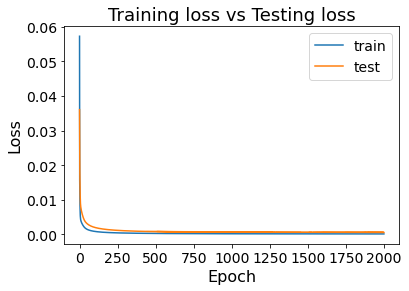

In [20]:
lr = 0.00001
EPOCHS = 2000
model_conv_mlp_60.compile(
              optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=500)
mc = ModelCheckpoint('../saved_model/cnn.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True)


history = model_conv_mlp_60.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=False,
                               callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [21]:
from tensorflow.keras.models import load_model

model_load = load_model('../saved_model/cnn.h5')

In [22]:
yhat = model_load.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (19249, 96) (19249, 96)


In [23]:
# inv_y

In [24]:
# inv_yhat

In [25]:
error_abs = abs(inv_yhat - inv_y)
# error_abs

In [26]:
error = inv_yhat - inv_y
# error

In [27]:
## 17544 = 24 * (365+366)
error_19_20 = error.iloc[-17544:, :]

In [28]:
len(error_19_20)

17544

In [29]:
inv_y.to_csv('../output/inv_y_cnn.csv')
inv_yhat.to_csv('../output/inv_yhat_cnn.csv')
error.to_csv('../output/error_cnn.csv')

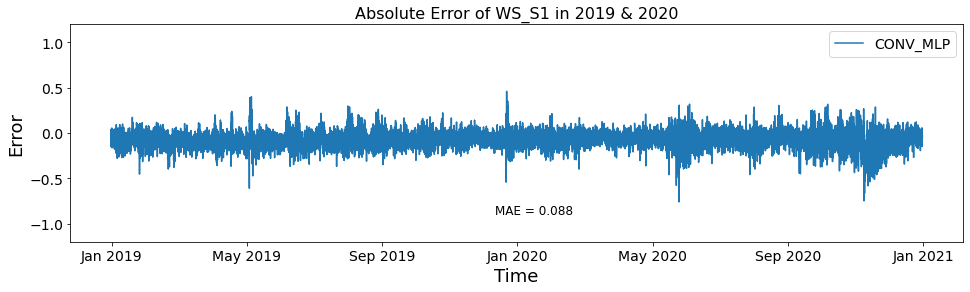

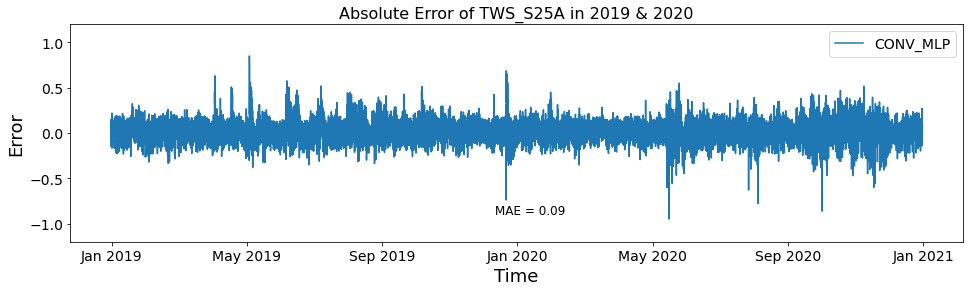

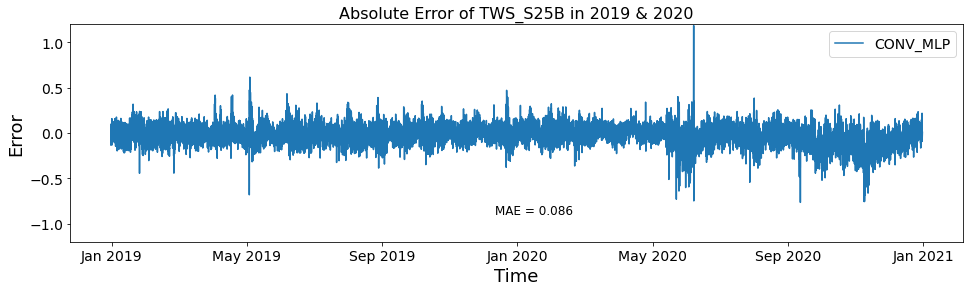

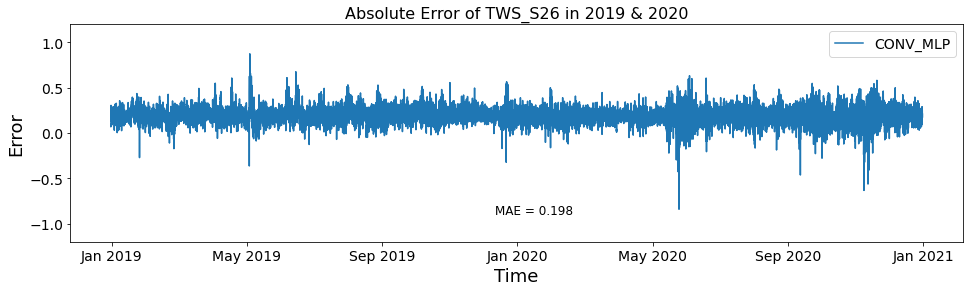

In [30]:
plt.rcParams["figure.figsize"] = (16, 4)
months = ['Jan 2019', 'May 2019', 'Sep 2019', 'Jan 2020', 'May 2020', 'Sep 2020', 'Jan 2021']

# 17544 = 24 hours * (365+366) days
# locations = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26', 'STORAGE', 'HWS_S25A', 'HWS_S25B']
locations = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
for i, col in enumerate([-4, -3, -2, -1]):
    plt.plot(error.iloc[-17544:, col], label='CONV_MLP')
    plt.xlabel('Time', fontsize=18)
    plt.ylabel('Error', fontsize=18)
    plt.ylim(-1.2, 1.2)
    plt.xticks(np.arange(1726, 19270, 2923), months, fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.title('Absolute Error of {} in 2019 & 2020'.format(locations[i]), fontsize=16)
    # plt.savefig('figures/Test_Error_rnn_chop.png', dpi=300)
    plt.text(10000, -0.9, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error.iloc[-17544:, col]))/17544))), fontsize=12)
    plt.show()
    plt.close()